In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.activations import relu
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, LeakyReLU, Dense, Input, Concatenate, Activation, LeakyReLU, Convolution2D

## Utils

In [2]:
def show_img(image, title=""):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{title}")
    plt.show()

def laplacian_kernel(images: list):
    try:
        res_imgs : list = list()
        laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        # gs_dims = (5, 5) # Gaussian smoothing
        # 
        for image in images:
            # image = cv2.GaussianBlur(image, gs_dims, 0)
            lk_image = apply_kernel(image, laplacian_kernel)
            res_imgs.append(lk_image)
        return np.array(res_imgs)
    except Exception as e:
        print(f"feature extraction with laplacian kernel: {e}")

def read_images(images_paths: list):
    try:
        res_images: list = list()
        for ip in images_paths:
            image = cv2.imread(ip, 0)
            dims = (200, 200)
            image = cv2.resize(image, dims, interpolation=cv2.INTER_AREA)
            res_images.append(image)
        return res_images
    # 
    except Exception as e:
        print(f"error reading image: {e}")
    
def apply_kernel(image: np.array, kernel: np.array):
    # edges = cv2.filter2D(src=image, cv2.CV_64F, kernel=kernel)
    edges = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    img_edges = np.uint8(np.absolute(edges))  # make to unsigned 8 bit int
    return img_edges

## Load Data

In [3]:
datapath = "./data.csv"
df = pd.read_csv(datapath)
df.head()

,filepath,filename,target,class
0,./data/data/green_area/Forest_2185.jpg,Forest_2185.jpg,2,green_area
1,./data/data/water/SeaLake_533.jpg,SeaLake_533.jpg,1,water
2,./data/data/cloudy/train_24777.jpg,train_24777.jpg,0,cloudy
3,./data/data/water/SeaLake_863.jpg,SeaLake_863.jpg,1,water
4,./data/data/desert/desert(625).jpg,desert(625).jpg,3,desert


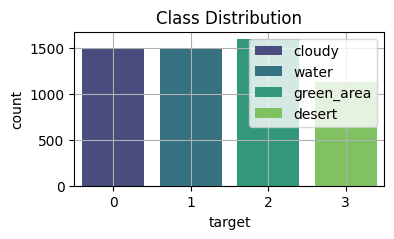

In [4]:
plt.figure(figsize=(4, 2))
sns.countplot(data=df, x="target", palette="viridis", hue='class')
plt.title("Class Distribution")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
data_paths = df['filepath'].values
data_images: list = read_images(data_paths)
len(data_images)

5731

## Feature Extraction

#### laplacian_kernel

In [6]:
filter_imgs: np.array = laplacian_kernel(data_images)
filter_imgs.shape

(5731, 200, 200)

## Data Split And Normalisation

In [7]:
filter_imgs = filter_imgs / 255.0

In [8]:
x_train, x_test, y_train, y_test  = train_test_split(filter_imgs, df['target'], test_size=0.2, random_state=18 ) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4584, 200, 200), (1147, 200, 200), (4584,), (1147,))

## Train

#### conv net

In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_train.shape

(4584, 4)

In [10]:
x_train.shape, y_train.shape

((4584, 200, 200), (4584, 4))

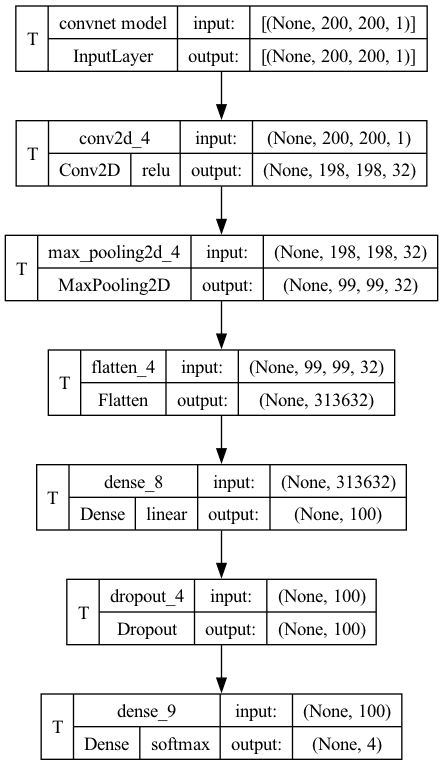

In [34]:
BATCH_SIZE = 16
DROPOUT_RATE = 0.4
LEARNING_RATE: int = 0.1e-3
INPUT_SHAPE = filter_imgs.shape[1:]
NUM_CLASSES = y_train.shape[-1]

#
input = Input(shape=(200, 200, 1), name="convnet model")
x = Convolution2D(32, 3, data_format='channels_last', activation="relu", input_shape=(200, 200, 1))(input)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)
x = Dense(100)(x)
x = Dropout(DROPOUT_RATE)(x)
# 
output = Dense(NUM_CLASSES, activation="softmax")(x)
# 
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

# convnet_layers_model
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True, show_trainable=True )


In [35]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnet model (InputLayer)  [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 313632)            0         
                                                                 
 dense_8 (Dense)             (None, 100)               31363300  
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                           

In [12]:
y_eval = keras.utils.to_categorical(y_test, NUM_CLASSES)
x_test.shape, y_eval.shape

((1147, 200, 200), (1147, 4))

In [13]:
x_train.shape, y_train.shape

((4584, 200, 200), (4584, 4))

In [14]:
EPOCHS = 20
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
                        #   validation_data=(x_test, y_eval), 
                          validation_split=0.2,
                          epochs=EPOCHS, verbose=1 )

Epoch 1/20
230/230 [==============================] - 27s 115ms/step - loss: 0.9709 - accuracy: 0.6708 - val_loss: 0.3828 - val_accuracy: 0.9149
Epoch 2/20
230/230 [==============================] - 36s 156ms/step - loss: 0.3019 - accuracy: 0.9040 - val_loss: 0.3172 - val_accuracy: 0.9019
Epoch 3/20
230/230 [==============================] - 42s 183ms/step - loss: 0.1424 - accuracy: 0.9654 - val_loss: 0.2110 - val_accuracy: 0.9302
Epoch 4/20
230/230 [==============================] - 40s 173ms/step - loss: 0.1285 - accuracy: 0.9689 - val_loss: 0.1391 - val_accuracy: 0.9662
Epoch 5/20
230/230 [==============================] - 37s 158ms/step - loss: 0.0733 - accuracy: 0.9790 - val_loss: 0.2857 - val_accuracy: 0.9455
Epoch 6/20
230/230 [==============================] - 27s 114ms/step - loss: 0.3310 - accuracy: 0.9425 - val_loss: 0.2027 - val_accuracy: 0.9575
Epoch 7/20
230/230 [==============================] - 24s 102ms/step - loss: 0.0801 - accuracy: 0.9885 - val_loss: 0.1460 - val_ac

#### Save Model To File

In [15]:
# model.save("./models/laplacian_convnet.keras")

## Evaluate

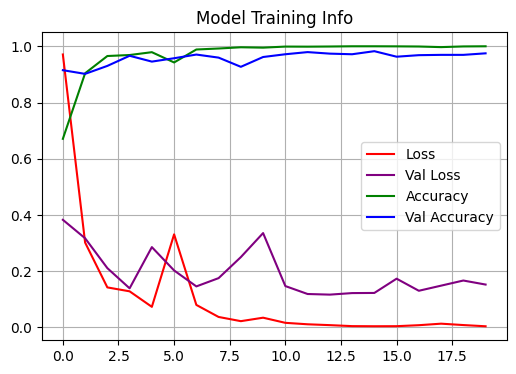

In [16]:
s = model_history.history

plt.figure(figsize=(6, 4))
plt.plot(s['loss'], label="Loss", color="red")
plt.plot(s['val_loss'], label="Val Loss", color="purple" )
plt.plot(s['accuracy'], label="Accuracy", color="green" )
plt.plot(s['val_accuracy'], label="Val Accuracy", color="blue" )
plt.title("Model Training Info")
plt.grid(True)
# y = [0, 1]
# plt.yticks(range(min(y), max(y)+1, 1))
plt.legend()
plt.show()

In [17]:
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_preds

36/36 [==============================] - 2s 55ms/step


array([2, 1, 0, ..., 3, 0, 2])

In [18]:
accuracy_score(y_test, y_preds)

0.96512641673932

In [19]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       296
           1       0.96      0.94      0.95       312
           2       0.93      0.96      0.95       303
           3       0.97      0.99      0.98       236

    accuracy                           0.97      1147
   macro avg       0.97      0.97      0.97      1147
weighted avg       0.97      0.97      0.97      1147



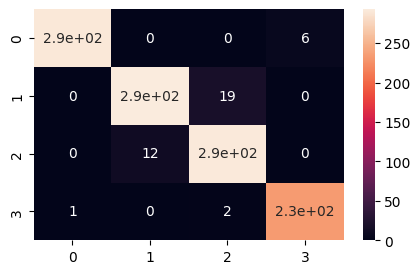

In [20]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.show()

## Test With Eval Data

In [21]:
eval_path = "./eval.csv"
eval = pd.read_csv(eval_path)
eval.head()

,filepath,filename,target,class
0,./data/sacair_data/validation/desert/desert(94...,desert(941).jpg,3,desert
1,./data/sacair_data/validation/cloudy/train_106...,train_10667.jpg,0,cloudy
2,./data/sacair_data/validation/water/SeaLake_13...,SeaLake_1313.jpg,1,water
3,./data/sacair_data/validation/green_area/Fores...,Forest_2137.jpg,2,green_area
4,./data/sacair_data/validation/water/SeaLake_13...,SeaLake_135.jpg,1,water


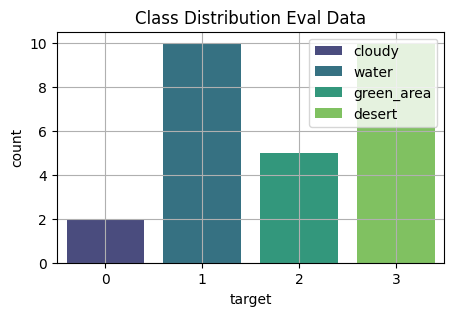

In [22]:
plt.figure(figsize=(5, 3))
sns.countplot(data=eval, x="target", palette="viridis", hue='class')
plt.title("Class Distribution Eval Data")
plt.grid(True)
plt.legend()
plt.show()

### Preprocess the image data

In [23]:
images_paths = eval['filepath'].values

In [24]:
eval_images_paths = eval['filepath'].values
y_eval = eval['target'].values

# load all images from files, into list variable
eval_images: list = read_images(eval_images_paths)

len(eval_images)

27

#### laplacian_kernel

In [25]:
# pass all images to kernel function to feature extraction
eval_imgs: np.array = laplacian_kernel(eval_images)
eval_imgs.shape

(27, 200, 200)

In [26]:
eval_preds = model.predict(eval_imgs)
eval_preds = np.argmax(eval_preds, axis=1)
eval_preds

1/1 [==============================] - 0s 219ms/step


array([3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2,
       3, 2, 3, 3, 2])

In [27]:
y_eval, eval_preds

(array([3, 0, 1, 2, 1, 0, 1, 3, 1, 1, 2, 1, 2, 3, 3, 2, 3, 3, 1, 1, 3, 2,
        3, 1, 3, 3, 1]),
 array([3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2,
        3, 2, 3, 3, 2]))

In [28]:
accuracy_score(y_eval, eval_preds)

0.5555555555555556

In [29]:
print(classification_report(y_eval, eval_preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       1.00      0.00      0.00        10
           2       0.29      1.00      0.45         5
           3       1.00      1.00      1.00        10

    accuracy                           0.56        27
   macro avg       0.82      0.50      0.36        27
weighted avg       0.87      0.56      0.45        27



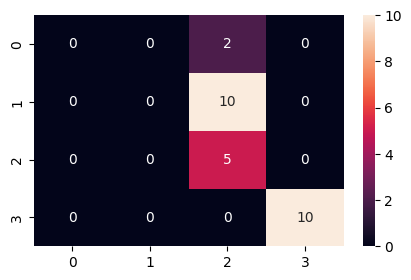

In [30]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_eval, eval_preds), annot=True)
plt.show()